<a href="https://colab.research.google.com/github/takzen/ai-engineering-handbook/blob/main/notebooks/074_Liquid_Neural_Networks_LFC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


<a href="https://colab.research.google.com/github/takzen/ai-engineering-handbook/blob/main/74_Liquid_Neural_Networks_LFC.ipynb" target="_parent">
    <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>


# 💧 Liquid Neural Networks: Sieci, które "płyną"

Standardowe RNN (jak LSTM) działają w dyskretnych krokach (krok 1, krok 2...).
Liquid Networks są oparte na **Równaniach Różniczkowych (ODE)**. Działają w czasie ciągłym.

**Kluczowa innowacja:**
W zwykłym neuronie waga $W$ jest stała.
W Liquid Network, szybkość reakcji neuronu (**Stała Czasowa $\tau$**) zależy od wejścia.

$$ \frac{dh(t)}{dt} = -\frac{h(t)}{\tau(x)} + f(x, h) $$

*   Gdy $\tau$ jest małe -> Neuron reaguje błyskawicznie (jak woda).
*   Gdy $\tau$ jest duże -> Neuron zachowuje pamięć (jak miód).

To sprawia, że sieć "dostosowuje swoją lepkość" do sytuacji. Zbudujemy komórkę LTC (Liquid Time-Constant).

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt

# Konfiguracja
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
INPUT_DIM = 1
HIDDEN_DIM = 16  # Wystarczy bardzo mało neuronów! (LSTM potrzebowałby 50-100)
OUTPUT_DIM = 1

print(f"Symulacja LNN na: {DEVICE}")

Symulacja LNN na: cuda


## Matematyka Komórki LTC

Zamiast używać gotowego solvera ODE (który jest wolny), użyjemy przybliżenia **Euler Integration**.
Dzięki temu możemy to zapisać jako szybką warstwę w PyTorch.

Dla każdego kroku czasowego:
1.  Obliczamy nową stałą czasową $\tau$ na podstawie wejścia (to jest ta "płynność").
2.  Obliczamy sygnał wejściowy (Sigmoid).
3.  Mieszamy stary stan z nowym, w proporcji zależnej od $\tau$.

$$ h_{new} = (h_{old} \cdot (1 - \frac{dt}{\tau})) + (sygnal \cdot \frac{dt}{\tau}) $$

In [2]:
class LiquidCell(nn.Module):
    def __init__(self, input_dim, hidden_dim):
        super().__init__()
        self.hidden_dim = hidden_dim
        
        # Wagi do obliczania sygnału
        self.weight_xh = nn.Linear(input_dim, hidden_dim)
        self.weight_hh = nn.Linear(hidden_dim, hidden_dim)
        
        # Wagi do obliczania Stałej Czasowej (Tau)
        # To jest unikalne dla Liquid Networks!
        self.weight_tau = nn.Linear(hidden_dim, hidden_dim)
        
    def forward(self, x, h_prev, dt=0.1):
        # 1. Obliczamy sygnał wejściowy (zwykły RNN)
        # Tanh spłaszcza wartości do [-1, 1]
        signal = torch.tanh(self.weight_xh(x) + self.weight_hh(h_prev))
        
        # 2. Obliczamy Tau (Płynność) zależną od stanu
        # Sigmoid + mała stała, żeby nie dzielić przez zero (tau > 0)
        # Tau zależy od h_prev - sieć sama decyduje, jak szybko chce się zmieniać!
        tau = torch.sigmoid(self.weight_tau(h_prev)) + 0.1
        
        # 3. Rozwiązanie równania różniczkowego (Metoda Eulera)
        # h(t+1) = h(t) + dh/dt * dt
        # dh/dt = -(h - signal) / tau
        
        # Wersja numerycznie stabilna (Leaky Integrator):
        # Mieszanka: (1 - alpha) * stare + alpha * nowe
        alpha = dt / tau
        # Clampujemy alpha do 0-1, żeby nie wybuchło przy dużym dt
        alpha = torch.clamp(alpha, 0.0, 1.0)
        
        h_new = (1 - alpha) * h_prev + alpha * signal
        
        return h_new

# Warstwa opakowująca (z pętlą czasu)
class LiquidNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.cell = LiquidCell(INPUT_DIM, HIDDEN_DIM)
        self.readout = nn.Linear(HIDDEN_DIM, OUTPUT_DIM)
        
    def forward(self, x):
        # x: [Batch, Time, Features]
        batch_size, seq_len, _ = x.shape
        
        # Stan początkowy (zera)
        h = torch.zeros(batch_size, HIDDEN_DIM).to(x.device)
        outputs = []
        
        for t in range(seq_len):
            x_t = x[:, t, :]
            h = self.cell(x_t, h)
            out = self.readout(h)
            outputs.append(out)
            
        return torch.stack(outputs, dim=1) # [Batch, Time, Output]

model = LiquidNetwork().to(DEVICE)
print(f"Liczba parametrów: {sum(p.numel() for p in model.parameters())}")
print("Zauważ, jak mało parametrów! (Ok. 600). LSTM miałby tysiące.")

Liczba parametrów: 593
Zauważ, jak mało parametrów! (Ok. 600). LSTM miałby tysiące.


## Test: Zaszumiona Sinusoida

Sprawdźmy, czy ta malutka sieć poradzi sobie z przewidywaniem szeregu czasowego, który jest mocno zaszumiony.
LNN słyną z odporności na szum.

In [3]:
# Generujemy dane (Sinusoida + Szum)
t = np.linspace(0, 100, 1000)
clean_signal = np.sin(t * 0.2)
noisy_signal = clean_signal + np.random.normal(0, 0.1, len(t)) # 10% szumu

# Przygotowanie tensorów [Batch, Time, Features]
# Uczymy na jednym długim ciągu (Batch=1)
input_seq = torch.tensor(noisy_signal[:-1], dtype=torch.float32).view(1, -1, 1).to(DEVICE)
target_seq = torch.tensor(clean_signal[1:], dtype=torch.float32).view(1, -1, 1).to(DEVICE)

# Trening
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
loss_fn = nn.MSELoss()

print("Start treningu...")
for epoch in range(200):
    optimizer.zero_grad()
    
    pred = model(input_seq)
    loss = loss_fn(pred, target_seq)
    
    loss.backward()
    optimizer.step()
    
    if epoch % 20 == 0:
        print(f"Epoka {epoch} | Loss: {loss.item():.5f}")

print("✅ Trening zakończony.")

Start treningu...
Epoka 0 | Loss: 1.12538
Epoka 20 | Loss: 0.00790
Epoka 40 | Loss: 0.00632
Epoka 60 | Loss: 0.00317
Epoka 80 | Loss: 0.00287
Epoka 100 | Loss: 0.00265
Epoka 120 | Loss: 0.00247
Epoka 140 | Loss: 0.00230
Epoka 160 | Loss: 0.00216
Epoka 180 | Loss: 0.00203
✅ Trening zakończony.


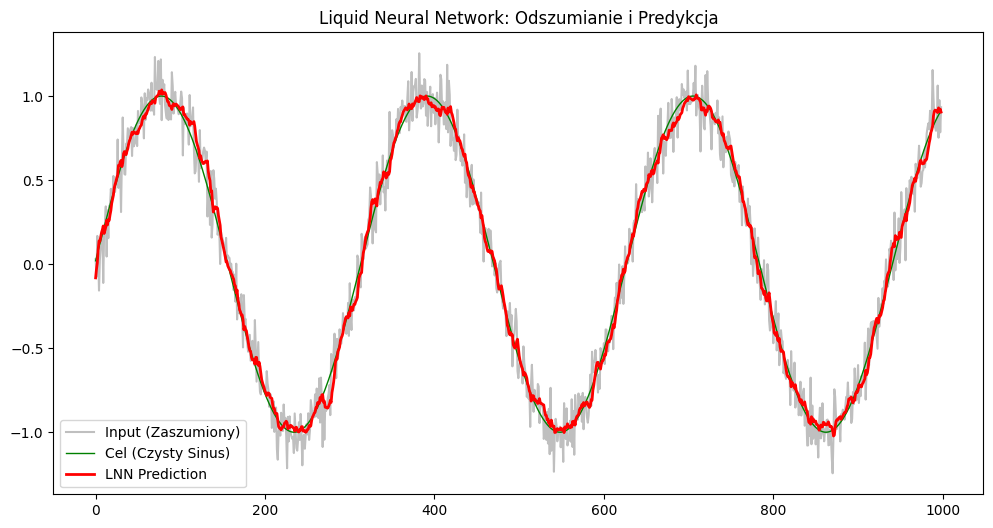

In [4]:
# Wizualizacja
model.eval()
with torch.no_grad():
    prediction = model(input_seq).cpu().numpy().flatten()

plt.figure(figsize=(12, 6))
plt.plot(noisy_signal[1:], label='Input (Zaszumiony)', color='gray', alpha=0.5)
plt.plot(target_seq.cpu().flatten(), label='Cel (Czysty Sinus)', color='green', linewidth=1)
plt.plot(prediction, label='LNN Prediction', color='red', linewidth=2)
plt.title("Liquid Neural Network: Odszumianie i Predykcja")
plt.legend()
plt.show()

## 🧠 Podsumowanie: Dlaczego to przyszłość robotyki?

Spójrz na wykres. Czerwona linia (LNN) powinna być **gładsza** niż szare tło (szum).
Sieć nauczyła się dynamiki fali, ignorując drgania.

Dlaczego to jest ważne?
Wyobraź sobie drona latającego w lesie.
*   Kamera trzęsie się, liście szumią (dużo zakłóceń).
*   Zwykła sieć (sztywna) próbowałaby reagować na każdy ruch liścia -> dron by wariował.
*   **LNN (Płynna)** "wygładza" rzeczywistość. Dostosowuje swoje $\tau$, żeby ignorować szybkie zmiany (szum), a reagować na wolne zmiany (przeszkoda).

To dlatego te sieci (mając zaledwie 19 neuronów!) potrafią sterować autonomicznymi samochodami lepiej niż wielkie CNN.